In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pandas.plotting import scatter_matrix as scatter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from sklearn.cluster import KMeans as kmeans
nltk.download('vader_lexicon') # To use the nltk sentiment analyzer, you must download the 'vader_lexicon' first.
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import sklearn.preprocessing as skp
import sklearn.feature_selection as skfs
from yellowbrick.text import FreqDistVisualizer # must pip install yellowbrick to run this import

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacob/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/jacob/enter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_us = pd.read_csv("./YouTube Data/USvideos.csv")
df_ca = pd.read_csv("./YouTube Data/CAvideos.csv")
df_uk = pd.read_csv("./YouTube Data/GBvideos.csv")
df_all_three = pd.concat([df_uk, df_us, df_ca])
df_us_uk = pd.concat([df_uk, df_us])

# Getting to Know the Data

In this brief section, we calculated the correlation between features in the us dataframe. We then calculated a correlation based on a dummy encoding of channels. This was with the intent of seeing the correlation between, for instance, views and the channel of a video. For most channels the correlation was relatively low.

In [25]:
df_us.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [178]:
df_us.corr(method ='pearson')

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
category_id,1.000000,-0.168231,-0.173921,-0.033547,-0.076307,0.048949,-0.013506,-0.030011
views,-0.168231,1.000000,0.849177,0.472213,0.617621,0.002677,0.015355,-0.002256
likes,-0.173921,0.849177,1.000000,0.447186,0.803057,-0.028918,-0.020888,-0.002641
dislikes,-0.033547,0.472213,0.447186,1.000000,0.700184,-0.004431,-0.008230,-0.001853
comment_count,-0.076307,0.617621,0.803057,0.700184,1.000000,-0.028277,-0.013819,-0.003725
comments_disabled,0.048949,0.002677,-0.028918,-0.004431,-0.028277,1.000000,0.319230,-0.002970
ratings_disabled,-0.013506,0.015355,-0.020888,-0.008230,-0.013819,0.319230,1.000000,-0.001526
video_error_or_removed,-0.030011,-0.002256,-0.002641,-0.001853,-0.003725,-0.002970,-0.001526,1.000000


In [179]:
df_us_drop = df_us.drop(columns = ["description", "title", "tags", "thumbnail_link", "video_id", "publish_time", "trending_date"])
df_us_drop = df_us_drop[0:50]
df_dummy = pd.get_dummies(df_us_drop)

In [181]:
df_dummy.corr(method ='pearson')

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,channel_title_20th Century Fox,channel_title_Amazon.co.uk,...,channel_title_Tom Scott,channel_title_U2VEVO,channel_title_Vox,channel_title_amc,channel_title_dope2111,channel_title_hp_overload,channel_title_iJustine,channel_title_marshmello,channel_title_nigahiga,channel_title_officer401
category_id,1.000000,-0.150853,-0.163037,-0.219174,-0.169460,0.066129,NaN,NaN,-0.354028,0.066129,...,0.120932,-0.189619,0.084397,0.066129,0.102664,-0.335760,0.139200,-0.189619,0.066129,0.066129
views,-0.150853,1.000000,0.982226,0.934912,0.976258,-0.045667,NaN,NaN,0.001152,-0.045667,...,-0.038737,-0.043647,-0.032182,-0.041068,0.038043,-0.041431,-0.040214,-0.006951,0.075452,-0.043229
likes,-0.163037,0.982226,1.000000,0.927843,0.986101,-0.043032,NaN,NaN,-0.038688,-0.043032,...,-0.028266,-0.036346,-0.027129,-0.041184,-0.000676,-0.038064,-0.030797,0.101686,0.124582,-0.038387
dislikes,-0.219174,0.934912,0.927843,1.000000,0.947234,-0.042734,NaN,NaN,-0.041617,-0.042734,...,-0.042287,-0.041907,-0.013814,-0.037504,-0.007176,-0.033213,-0.032856,-0.014485,0.000177,-0.042399
comment_count,-0.169460,0.976258,0.986101,0.947234,1.000000,-0.040681,NaN,NaN,-0.037936,-0.040681,...,-0.032496,-0.037008,-0.021566,-0.030356,-0.023245,-0.036758,-0.029105,0.026892,0.100729,-0.035628
comments_disabled,0.066129,-0.045667,-0.043032,-0.042734,-0.040681,1.000000,NaN,NaN,-0.020408,1.000000,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
ratings_disabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_error_or_removed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_title_20th Century Fox,-0.354028,0.001152,-0.038688,-0.041617,-0.037936,-0.020408,NaN,NaN,1.000000,-0.020408,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408
channel_title_Amazon.co.uk,0.066129,-0.045667,-0.043032,-0.042734,-0.040681,1.000000,NaN,NaN,-0.020408,1.000000,...,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408,-0.020408


# Mutual Info Regressions

In this step, we aim to show the value of mutual information contributed by different words when it comes to views/likes/dislikes/comment count, as well as the mutual information value between other features.

The first function below will display the 10 words with the highest mutual information amount, based on the target (such as 'views') and the in_feature ('title', 'tag', or 'description') for each and every category in the provided dataframe.

In [4]:
count_vectorizer = CountVectorizer(stop_words='english')

In [114]:
def mutual_info(df, target, in_feature):
    count_vectorizer = CountVectorizer(stop_words='english')
    for i in df['category_id'].unique():
        X = count_vectorizer.fit_transform(df[in_feature].values.astype('U')[df['category_id'] == i])
        Y = df[target][df['category_id'] == i]
        res = dict(zip(count_vectorizer.get_feature_names(),
        skfs.mutual_info_regression(X, Y, discrete_features=True)
               ))
        print("Category: " + str(i))
        print(sorted(res.items(), key=lambda x: x[1], reverse = True)[0:10])
        print("\n")

The next function below will do the same, but only for the specified category parameter category_num (such as 23).

In [115]:
def mutual_info_cat(df, target, in_feature, category_num):
    count_vectorizer = CountVectorizer(stop_words='english')
    for i in df['category_id'].unique():
        if (i == category_num):
            X = count_vectorizer.fit_transform(df[in_feature].values.astype('U')[df['category_id'] == i])
            Y = df[target][df['category_id'] == i]
            res = dict(zip(count_vectorizer.get_feature_names(),
               skfs.mutual_info_regression(X, Y, discrete_features=True)
               ))
            print("Category: " + str(i))
            print(sorted(res.items(), key=lambda x: x[1], reverse = True)[0:10])
            print("\n")

Examples:

In [116]:
mutual_info(df_us, 'views', 'title')

Category: 22
[('primitive', 0.030911439814525488), ('technology', 0.030911439814525488), ('grace', 0.028626645514697957), ('helbig', 0.028626645514697957), ('interview', 0.02797910615948651), ('charlamagne', 0.027356605541006718), ('kanye', 0.027356605541006718), ('west', 0.027356605541006718), ('makeup', 0.027147657043132822), ('fan', 0.026940766385219028)]


Category: 24
[('official', 0.06808033882642217), ('trailer', 0.05102792502694298), ('hd', 0.02492275010235434), ('talk', 0.019837912509623412), ('studios', 0.01971914930994867), ('movie', 0.01846344311806436), ('2018', 0.017398247648186427), ('react', 0.016863928526823946), ('hirani', 0.016714144279337817), ('kapoor', 0.016714144279337817)]


Category: 23
[('lele', 0.051676449869815455), ('pons', 0.051676449869815455), ('reading', 0.039423134321247666), ('lip', 0.03861608189443255), ('bad', 0.03607158830646284), ('royal', 0.032957875351119825), ('yiay', 0.03173266984833667), ('wedding', 0.030411665223142204), ('10', 0.02576197830

In [113]:
mutual_info_cat(df_us, 'views', 'title', 1)

Category: 1
[('teaser', 0.06651216928551218), ('honest', 0.06285747029645683), ('trailer', 0.05953491315128301), ('trailers', 0.05147993396061312), ('spider', 0.05138293705630548), ('2018', 0.048490384010604126), ('rooster', 0.048079155862638334), ('teeth', 0.048079155862638334), ('robin', 0.04703867283424046), ('lucas', 0.04680808246323709)]




The below function takes a dataframe and computes the mutual information between all numeric features. It doesn't include text features because when text is computed to a count vectorizer, it can't be evaluated as normal in a dataframe unless we essentially dummy encode it. Note that the below function takes a little while to run (10-15 minutes).

In [63]:
def mutual_info_numeric(df):
    df_num = df._get_numeric_data()
    reg_list = []
    feat_list = []
    for i in df_num:
        current_reg = skfs.mutual_info_regression(df_num, df_num[i])
        reg_list.append(current_reg)
        feat_list.append(i)
        
    df_res = pd.DataFrame(reg_list, index = feat_list, columns = feat_list)
    return df_res

In [57]:
mutual_info_numeric(df_us)

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
category_id,2.334330,0.096592,0.175457,0.104966,0.148838,0.001152,0.003322,0.000000
views,0.096594,9.359292,1.013781,0.884235,0.812057,0.005456,0.003497,0.000000
likes,0.175434,1.013978,9.192271,0.911499,1.214222,0.017228,0.026536,0.000000
dislikes,0.106871,0.884361,0.912027,7.908709,1.077184,0.009589,0.019894,0.000000
comment_count,0.146018,0.811983,1.213687,1.076980,8.556891,0.074584,0.007614,0.001677
comments_disabled,0.008559,0.005528,0.018346,0.008918,0.072209,0.076611,0.003953,0.001547
ratings_disabled,0.007122,0.003497,0.025928,0.020456,0.007370,0.004920,0.023202,0.001307
video_error_or_removed,0.000000,0.000000,0.000000,0.000000,0.000131,0.000000,0.000000,0.002397


In [59]:
df_ca_mutual_info = mutual_info_numeric(df_ca)

In [62]:
print(df_ca_mutual_info)

                        category_id     views     likes  dislikes  \
category_id                2.211732  0.100098  0.161659  0.078247   
views                      0.100134  9.355261  0.662985  0.795522   
likes                      0.161915  0.662979  9.082447  0.597386   
dislikes                   0.077952  0.795371  0.598285  7.365441   
comment_count              0.074619  0.477756  0.756455  0.554363   
comments_disabled          0.009097  0.004993  0.008828  0.004543   
ratings_disabled           0.004042  0.001843  0.041667  0.034247   
video_error_or_removed     0.001004  0.000000  0.002064  0.000000   

                        comment_count  comments_disabled  ratings_disabled  \
category_id                  0.072750           0.007357          0.000000   
views                        0.477489           0.005013          0.001856   
likes                        0.755001           0.009227          0.039830   
dislikes                     0.553846           0.011241          

In [58]:
mutual_info_numeric(df_uk)

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
category_id,1.988498,0.172687,0.254702,0.205178,0.249591,0.002709,0.005927,0.000635
views,0.172637,9.308886,1.340970,1.122191,1.029373,0.006787,0.006836,0.001588
likes,0.254433,1.341066,9.171893,1.238361,1.538051,0.028884,0.040893,0.002643
dislikes,0.200418,1.122200,1.239594,8.093676,1.415008,0.026955,0.035613,0.000000
comment_count,0.247925,1.029658,1.537228,1.414031,8.636767,0.083214,0.020706,0.004091
comments_disabled,0.009514,0.006816,0.028324,0.027096,0.081369,0.085058,0.020610,0.000000
ratings_disabled,0.007132,0.006900,0.040716,0.039475,0.024182,0.019358,0.052056,0.000000
video_error_or_removed,0.000000,0.001613,0.001384,0.002236,0.001828,0.000000,0.000000,0.012689


# Predictive Regressions

In the following section we train multiple regression models on several text columns (title, tags, and channel title) and use them to determine a feature value such as likes, dislikes, views or comment_count. 

We start with a linear regression.

The trained model can then be used in the prediction_engagement function to predict the feature value based on the words/text in the title, channel and tags.

In [3]:
count_vectorizer = CountVectorizer(stop_words='english')

To train the model, call the function with a dataframe, and the feature that you are trying to predict (such as views). The current train/test split is 80/20.

In [4]:
def train_model(df, feature):
    df_res = df.copy(deep = True)
    df_res['title_channel_tags'] = df_res['title'] + df_res['tags'] + df_res['channel_title']
    X = count_vectorizer.fit_transform(df_res['title_channel_tags'])
    Y = df_res[feature]
    X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20)
    regression = LinearRegression()
    regression.fit(X_train, y_train)
    lr_prediction = regression.predict(X_test)
    print("The R squared of the model is: " + str(regression.score(X_test, y_test)))
    return df_res, regression

To predict the specific number associated with text, first train a model, and then provide the text and the model as parameters to the function.

In [5]:
def prediction_engagement(text, regression):
    user_text = count_vectorizer.transform([text])
    return abs(regression.predict(user_text)[0])

In [6]:
btsvid = "BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official MV BIGHIT|'빅히트'|'방탄소년단'|'BTS'|'BANGTAN'|'방탄'\
'Big Hit Labels'"
test_phrase = "testing hello world this is an awesome prediction tool!"

In [6]:
df_us_mod, us_reg = train_model(df_us, 'likes')

The R squared of the model is: 0.9093232853419582


In [7]:
df_us_mod, us_reg = train_model(df_us, 'views')

The R squared of the model is: 0.7909697876650965


In [21]:
df_us_mod_com, us_reg_com = train_model(df_us, 'comment_count')

The R squared of the model is: 0.959782045009414


In [40]:
prediction_engagement(btsvid, us_reg_com)

123695.7951954172

In [7]:
df_uk_mod, uk_reg = train_model(df_uk, 'comment_count')

The R squared of the model is: 0.9644694387284977


In [8]:
prediction_engagement(test_phrase, uk_reg)

22916.848018944343

Additionally, here's an update of the linear regression model, including a combined dataframe of both the US and UK. While the R-Squared is slightly lower than the purely UK or US model, it is still reasonably high and it advantageously covers both geographies.

In [27]:
df_all_mod, all_reg = train_model(df_us_uk, 'likes')

The R squared of the model is: 0.8898842650032252


In [29]:
df_all_mod, all_reg = train_model(df_us_uk, 'views')

The R squared of the model is: 0.7698383829157212


In [31]:
df_all_mod, all_reg = train_model(df_us_uk, 'comment_count')

The R squared of the model is: 0.9320874928030283


While the linear model works quite well for the US and GB, for an undetermined reason it doesn't fit the Canada dataset. We end up with a negative r-squared as detailed below. To remedy these, we then tried other models.

In [12]:
df_ca_mod, ca_reg_v = train_model(df_ca, 'views')

The R squared of the model is: -2.0975901974005313


In [13]:
prediction_engagement(btsvid, ca_reg_v)

18260942.051037945

In [14]:
df_ca_mod, ca_reg_l = train_model(df_ca, 'likes')

The R squared of the model is: -0.4302229079072086


In [15]:
prediction_engagement(btsvid, ca_reg_l)

34159.07117746099

In [43]:
df_ca_mod, ca_reg_c = train_model(df_ca, 'comment_count')

The R squared of the model is: -5.118135902570359


In [44]:
prediction_engagement(btsvid, ca_reg_c)

107650.4372102363

Let's see how a couple of other models perform on the Canada dataset, and then how they perform on the other geographies.

In [16]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
def train_model_gradient(df, feature):
    df_res = df.copy(deep = True)
    df_res['title_channel_tags'] = df_res['title'] + df_res['tags'] + df_res['channel_title']
    X = count_vectorizer.fit_transform(df_res['title_channel_tags'])
    Y = df_res[feature]
    X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20)
    regression = GradientBoostingRegressor()
    regression.fit(X_train, y_train)
    lr_prediction = regression.predict(X_test)
    print("The R squared of the model is: " + str(regression.score(X_test, y_test)))
    return df_res, regression

In [18]:
df_ca_mod, ca_reg = train_model_gradient(df_ca, 'likes')

The R squared of the model is: 0.6439610321166606


In [19]:
df_us_grad, us_reg_grad = train_model_gradient(df_us, 'views')

The R squared of the model is: 0.6662469803396212


In [20]:
prediction_engagement(btsvid, us_reg_grad)

5225465.602412286

In [22]:
df_us_grad, us_reg_gradl = train_model_gradient(df_us, 'likes')

The R squared of the model is: 0.764851077328352


In [23]:
prediction_engagement(btsvid, us_reg_gradl)

400450.2350222298

In [24]:
df_us_grad, us_reg_grad_comm = train_model_gradient(df_us, 'comment_count')

The R squared of the model is: 0.8329281244213975


In [25]:
prediction_engagement(btsvid, us_reg_grad_comm)

28285.18378278805

As we will see below the Bagging Regressor works pretty well on Canada in terms of r-squared value, but it has low prediction values. The same holds for the US and GB, each of which have a slightly higher r-squared than with the linear model.

In [27]:
def train_model_bagging(df, feature):
    df_res = df.copy(deep = True)
    df_res['title_channel_tags'] = df_res['title'] + df_res['tags'] + df_res['channel_title']
    X = count_vectorizer.fit_transform(df_res['title_channel_tags'])
    Y = df_res[feature]
    X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20)
    regression = BaggingRegressor()
    regression.fit(X_train, y_train)
    lr_prediction = regression.predict(X_test)
    print("The R squared of the model is: " + str(regression.score(X_test, y_test)))
    return df_res, regression

In [14]:
df_ca_mod, ca_reg = train_model_bagging(df_ca, 'likes')

The R squared of the model is: 0.8831804402839778


In [15]:
df_ca_mod, ca_reg = train_model_bagging(df_ca, 'views')

The R squared of the model is: 0.7040802940713182


In [45]:
df_ca_mod_bag, ca_reg_bag = train_model_bagging(df_ca, 'comment_count')

The R squared of the model is: 0.8964027765206364


In [46]:
prediction_engagement(btsvid, ca_reg_bag)

19263.63333333333

In [18]:
df_us_mod_bagcom, us_reg_bagcom = train_model_bagging(df_us, 'comment_count')

The R squared of the model is: 0.9488956592574043


In [41]:
prediction_engagement(btsvid, us_reg_bagcom)

20079.75772727273

In [9]:
df_us_mod, us_reg = train_model_bagging(df_us, 'likes')

The R squared of the model is: 0.9565816757612456


In [16]:
df_us_mod_bag, us_reg_bag = train_model_bagging(df_us, 'views')

The R squared of the model is: 0.8523774146770313


In [20]:
df_uk_mod, uk_reg = train_model_bagging(df_uk, 'views')

The R squared of the model is: 0.8201523145874698


In [21]:
df_uk_mod, uk_reg = train_model_bagging(df_uk, 'likes')

The R squared of the model is: 0.9391994401356413


In [22]:
df_uk_mod, uk_reg = train_model_bagging(df_uk, 'comment_count')

The R squared of the model is: 0.9850191820356453


Next let's try the model on a combined dataset consisting of all three geographies

Notice the very low values being predicted.

In [28]:
df_all_three_mod, df_all_three_reg_v = train_model_bagging(df_all_three, 'views')

The R squared of the model is: 0.7743994137274104


In [29]:
prediction_engagement(test_phrase, df_all_three_reg_v)

56903.225

In [35]:
df_all_three_mod, df_all_three_reg_l = train_model_bagging(df_all_three, 'likes')

The R squared of the model is: 0.9274052018603387


In [41]:
prediction_engagement(test_phrase, df_all_three_reg_l)

5637.212976190476

In [25]:
df_all_three_mod, df_all_three_reg = train_model_bagging(df_all_three, 'comment_count')

The R squared of the model is: 0.9674304456777278


In [52]:
prediction_engagement(test_phrase, df_all_three_reg)

323.4192857142857

# Sentiment Analysis

The below function takes a dataframe (such as df_us) and a text_feature (such as 'title', 'description' or 'tags') and calculates the percentage of instances which have positive, negative or neutral sentiment. This information is then displayed. The sentiment calculations can be changed based on the threshold, set currently at 0.3.

In [25]:
def sentiment_analyzer(df, text_feature):
    sentiment_analysis = SIA()
    sentiment_results = []
    for i in df[text_feature]:
        ps = sentiment_analysis.polarity_scores(str(i))
        ps[text_feature] = i
        sentiment_results.append(ps)
    df_sentiment = pd.DataFrame.from_records(sentiment_results)
    df_sentiment['Sentiment'] = 'Neutral'
    df_sentiment.loc[df_sentiment['compound'] > 0.3, 'Sentiment'] = 'Positive'
    df_sentiment.loc[df_sentiment['compound'] < -0.3, 'Sentiment'] = 'Negative'
    pos_lam = df_sentiment.apply(lambda x: True if x['Sentiment'] == 'Positive' else False, axis = 1)
    neg_lam = df_sentiment.apply(lambda x: True if x['Sentiment'] == 'Negative' else False, axis = 1)
    neu_lam = df_sentiment.apply(lambda x: True if x['Sentiment'] == 'Neutral' else False, axis = 1)
    pos_count = len(pos_lam[pos_lam == True].index)
    neg_count = len(neg_lam[neg_lam == True].index)
    neu_count = len(neu_lam[neu_lam == True].index)
    total_count = pos_count + neg_count + neu_count
    pos_percent = (pos_count/total_count) * 100
    neg_percent = (neg_count/total_count) * 100
    neu_percent = (neu_count/total_count) * 100
    
    print("The percentage of positive sentiment text features is: " + str(round(pos_percent,2)) + "%")
    print("The percentage of negative sentiment text features is: " + str(round(neg_percent,2)) + "%")
    print("The percentage of neutral sentiment text features is: " + str(round(neu_percent,2)) + "%")
    return df_sentiment

In [15]:
df_sus = sentiment_analyzer(df_us, 'description')

The percentage of positive sentiment text features is: 67.55%
The percentage of negative sentiment text features is: 11.34%
The percentage of neutral sentiment text features is: 21.1%


In [51]:
df_sus.head()

,neg,neu,pos,compound,description,Sentiment
0,0.041,0.882,0.077,0.7038,SHANTELL'S CHANNEL - https://www.youtube.com/s...,Positive
1,0.000,0.922,0.078,0.6705,"One year after the presidential election, John...",Positive
2,0.000,0.932,0.068,0.5882,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Positive
3,0.000,0.962,0.038,0.5274,Today we find out if Link is a Nickelback amat...,Positive
4,0.000,0.774,0.226,0.9290,I know it's been a while since we did this sho...,Positive


In [45]:
df_sca = sentiment_analyzer(df_ca, 'tags')

The percentage of positive sentiment text features is: 13.5%
The percentage of negative sentiment text features is: 9.12%
The percentage of neutral sentiment text features is: 77.38%


In [46]:
df_sca.head()

,neg,neu,pos,compound,tags,Sentiment
0,0.0,1.0,0.0,0.0000,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",Neutral
1,0.0,1.0,0.0,0.0000,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",Neutral
2,0.2,0.8,0.0,-0.6124,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",Negative
3,0.0,1.0,0.0,0.0000,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",Neutral
4,0.0,1.0,0.0,0.0000,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",Neutral


In [47]:
df_sca['compound'].describe()

count    40881.000000
mean         0.023041
std          0.298755
min         -0.995700
25%          0.000000
50%          0.000000
75%          0.000000
max          0.996800
Name: compound, dtype: float64

In [49]:
df_suk = sentiment_analyzer(df_uk, 'title')

The percentage of positive sentiment text features is: 17.98%
The percentage of negative sentiment text features is: 14.04%
The percentage of neutral sentiment text features is: 67.98%


# Clustering

In the following section, we used kmeans clustering on each of the dataframes. Because of the issues with putting a count vectorizer into a dataframe, text data is not accounted for in the clusters. Clustering was done to see how kmeans might cluster the data based on the numeric features, and if we could learn any new insights. For example, it seemed like certain categories might get clustered together. In practice, it appears to be influenced by the level of user engagement that each instance/video gets.

# United States

In [185]:
df2 = df_us._get_numeric_data()
df2 = df2.drop(columns='views')

In [186]:
model = kmeans(n_clusters = 3).fit(df2)

In [187]:
cross = pd.crosstab(df_us['category_id'], model.labels_)
print(cross)

col_0           0    1     2
category_id                 
1            2201    0   144
2             384    0     0
10           5257  151  1064
15            920    0     0
17           2038    0   136
19            402    0     0
20            788    0    29
22           3118    7    85
23           3351    0   106
24           9668   19   277
25           2487    0     0
26           4106    0    40
27           1656    0     0
28           2379    0    22
29             48    7     2
43             57    0     0


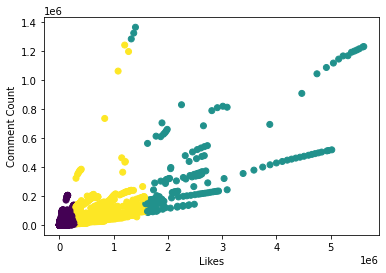

In [192]:
plt.xlabel('Likes')
plt.ylabel('Comment Count')
scatter = plt.scatter(df_us['likes'], df_us['comment_count'], c = model.labels_)

# Canada

In [194]:
df2 = df_ca._get_numeric_data()
df2 = df2.drop(columns='views')

In [195]:
model = kmeans(n_clusters = 3).fit(df2)

In [196]:
cross = pd.crosstab(df_ca['category_id'], model.labels_)
print(cross)

col_0            0   1    2
category_id                
1             1958   0  102
2              353   0    0
10            2983  74  674
15             368   0    1
17            2707   0   80
19             392   0    0
20            1304   0   40
22            4029   5   71
23            3524   0  249
24           13055  25  371
25            4153   0    6
26            1985   0   22
27             982   0    9
28            1129   0   26
29              63   5    6
30               6   0    0
43             124   0    0


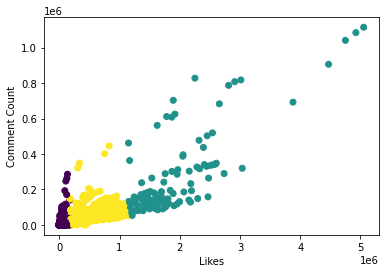

In [198]:
plt.xlabel('Likes')
plt.ylabel('Comment Count')
scatter = plt.scatter(df_ca['likes'], df_ca['comment_count'], c = model.labels_)

# Great Britain

In [199]:
df2 = df_uk._get_numeric_data()
df2 = df2.drop(columns='views')

In [200]:
model = kmeans(n_clusters = 3).fit(df2)

In [202]:
cross = pd.crosstab(df_uk['category_id'], model.labels_)
print(cross)

col_0            0    1     2
category_id                  
1             2577    0     0
2              144    0     0
10           11887  251  1616
15             534    0     0
17            1871    0    36
19              96    0     0
20            1758    0    30
22            2910    0    16
23            1787    0    41
24            8925   31   168
25            1205    0    20
26            1928    0     0
27             457    0     0
28             518    0     0
29              78    8     4
43              20    0     0


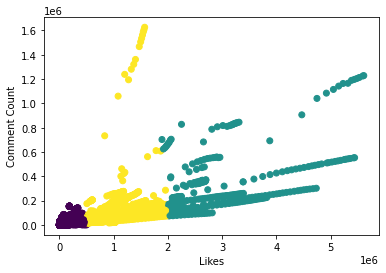

In [204]:
plt.xlabel('Likes')
plt.ylabel('Comment Count')
scatter = plt.scatter(df_uk['likes'], df_uk['comment_count'], c = model.labels_)

# Visualizations & Presentation Work

The following section includes some visualizations and data for our presentation/paper.

First, we have a kmeans cluster on a combined dataframe of the US, UK, and CA. The below cluster doesn't reveal much more than the earlier clusters in this notebook, but it is interesting to see the combined dataframe results nonetheless.

In [17]:
df_cluster = df_all_three._get_numeric_data()
df_cluster = df_cluster.drop(columns='views')

In [18]:
model = kmeans(n_clusters = 3).fit(df_cluster)

In [19]:
cross = pd.crosstab(df_all_three['category_id'], model.labels_)
print(cross)

col_0            0     1    2
category_id                  
1             6773   209    0
2              881     0    0
10           19553  3882  522
15            1823     0    0
17            6666   202    0
19             890     0    0
20            3893    56    0
22           10109   122   10
23            8869   189    0
24           31794   672   73
25            7845    26    0
26            8067    14    0
27            3082    22    0
28            4011    63    0
29             195     4   22
30               6     0    0
43             201     0    0


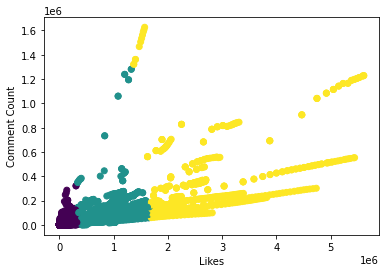

In [21]:
plt.xlabel('Likes')
plt.ylabel('Comment Count')
scatter = plt.scatter(df_cluster['likes'], df_cluster['comment_count'], c = model.labels_)

Earlier we calculated the mutual information using a specific category. Below we've created a function that computes the mutual information for an entire dataframe on 'title'. This takes a very long time to run for the US and UK, and we couldn't get it to finish within several hours for Canada. Still, the UK and US results offer some interesting insights into which words lead to a higher number of likes.

In [3]:
def mutual_info_nocat(df, target, in_feature):
    count_vectorizer = CountVectorizer(stop_words='english')
    X = count_vectorizer.fit_transform(df[in_feature].values.astype('U'))
    Y = df[target]
    res = dict(zip(count_vectorizer.get_feature_names(),
    skfs.mutual_info_regression(X, Y, discrete_features=True)
               ))
    return sorted(res.items(), key=lambda x: x[1], reverse = True)

In [16]:
df_us['title_tags'] = df_us['title'] + df_us['tags']

In [18]:
popular_words = mutual_info_nocat(df_us, 'likes', 'title')

In [19]:
print(popular_words)

[('official', 0.02549286744536805), ('video', 0.02534307891042764), ('bts', 0.012990264514591066), ('news', 0.012010049068584605), ('방탄소년단', 0.00981062865219251), ('2018', 0.00974145985311936), ('highlights', 0.00945856305936521), ('game', 0.00926061453659388), ('mv', 0.009245283877882704), ('dude', 0.008816161809016121), ('makeup', 0.008052010210283456), ('talk', 0.007894239630415578), ('love', 0.007844094818458491), ('ft', 0.007824681160551572), ('theory', 0.007647140847832246), ('nbc', 0.007582297262647475), ('perfect', 0.007529945976596952), ('spider', 0.007426455865958026), ('nba', 0.007191547212152205), ('fake', 0.006620880663405271), ('cardi', 0.006579514213860604), ('18', 0.00649008796797057), ('hawaii', 0.006461306289409996), ('movie', 0.006310079823439896), ('childish', 0.006179748552969988), ('gambino', 0.006179748552969988), ('fortnite', 0.0061770225833680525), ('studios', 0.006172058970538963), ('volcano', 0.006074600842400302), ('episode', 0.006012323378584594), ('deadpoo

In [4]:
popular_words_uk = mutual_info_nocat(df_uk, 'likes', 'title')

In [5]:
print(popular_words_uk)

[('video', 0.05005505346909933), ('official', 0.037475853490918976), ('ft', 0.03180813554641038), ('trump', 0.01933687510672133), ('mv', 0.0173091899226272), ('vs', 0.015377146430493926), ('new', 0.015134612770355771), ('2017', 0.014306992051918543), ('star', 0.014244657650094306), ('wars', 0.013423938392454815), ('2018', 0.013411858822454104), ('oficial', 0.012952814927706613), ('teaser', 0.011673384182303459), ('balvin', 0.011108894809938152), ('bts', 0.011058922147314965), ('look', 0.010936286921982896), ('bbc', 0.010934711746962034), ('ufc', 0.010798186969721901), ('tyron', 0.010774558927479583), ('woodley', 0.010774558927479583), ('news', 0.01077329311831876), ('super', 0.010721983184075246), ('like', 0.010699507435703137), ('ball', 0.010647614872844158), ('bunny', 0.010533583368188881), ('president', 0.010277695591318303), ('feat', 0.010040727339780453), ('방탄소년단', 0.01003028858164956), ('hollywood', 0.009984445471765357), ('beatdown', 0.009783552543556118), ('white', 0.0096693832

Here's a further breakdown of the sentiment, focusing on the 'description' for all three countries, plus tags and title for the US.

In [70]:
def sentiment_analyzer_ret(df, text_feature):
    sentiment_analysis = SIA()
    sentiment_results = []
    for i in df[text_feature]:
        ps = sentiment_analysis.polarity_scores(str(i))
        ps[text_feature] = i
        sentiment_results.append(ps)
    df_sentiment = pd.DataFrame.from_records(sentiment_results)
    df_sentiment['Sentiment'] = 'Neutral'
    df_sentiment.loc[df_sentiment['compound'] > 0.3, 'Sentiment'] = 'Positive'
    df_sentiment.loc[df_sentiment['compound'] < -0.3, 'Sentiment'] = 'Negative'
    pos_lam = df_sentiment.apply(lambda x: True if x['Sentiment'] == 'Positive' else False, axis = 1)
    neg_lam = df_sentiment.apply(lambda x: True if x['Sentiment'] == 'Negative' else False, axis = 1)
    neu_lam = df_sentiment.apply(lambda x: True if x['Sentiment'] == 'Neutral' else False, axis = 1)
    pos_count = len(pos_lam[pos_lam == True].index)
    neg_count = len(neg_lam[neg_lam == True].index)
    neu_count = len(neu_lam[neu_lam == True].index)
    total_count = pos_count + neg_count + neu_count
    pos_percent = (pos_count/total_count) * 100
    pos_percent = round(pos_percent, 1)
    neg_percent = (neg_count/total_count) * 100
    neg_percent = round(neg_percent, 1)
    neu_percent = (neu_count/total_count) * 100
    neu_percent = round(neu_percent, 1)
    
    print("The percentage of positive sentiment text features is: " + str(pos_percent) + "%")
    print("The percentage of negative sentiment text features is: " + str(neg_percent) + "%")
    print("The percentage of neutral sentiment text features is: " + str(neu_percent) + "%")
    return pos_percent, neg_percent, neu_percent, df_sentiment

In [71]:
us_desc_pos, us_desc_neg, us_desc_neu, df_sus = sentiment_analyzer_ret(df_us, 'description')

The percentage of positive sentiment text features is: 67.6%
The percentage of negative sentiment text features is: 11.3%
The percentage of neutral sentiment text features is: 21.1%


In [72]:
us_title_pos, us_title_neg, us_title_neu, df_sus = sentiment_analyzer_ret(df_us, 'title')

The percentage of positive sentiment text features is: 19.7%
The percentage of negative sentiment text features is: 13.4%
The percentage of neutral sentiment text features is: 66.9%


In [73]:
us_tags_pos, us_tags_neg, us_tags_neu, df_sus = sentiment_analyzer_ret(df_us, 'tags')

The percentage of positive sentiment text features is: 16.3%
The percentage of negative sentiment text features is: 8.3%
The percentage of neutral sentiment text features is: 75.4%


In [74]:
uk_desc_pos, uk_desc_neg, uk_desc_neu, df_suk = sentiment_analyzer_ret(df_uk, 'description')

The percentage of positive sentiment text features is: 56.5%
The percentage of negative sentiment text features is: 13.1%
The percentage of neutral sentiment text features is: 30.4%


In [75]:
uk_title_pos, uk_title_neg, uk_title_neu, df_suk = sentiment_analyzer_ret(df_uk, 'title')

The percentage of positive sentiment text features is: 18.0%
The percentage of negative sentiment text features is: 14.0%
The percentage of neutral sentiment text features is: 68.0%


In [76]:
uk_tags_pos, uk_tags_neg, uk_tags_neu, df_suk = sentiment_analyzer_ret(df_uk, 'tags')

The percentage of positive sentiment text features is: 14.6%
The percentage of negative sentiment text features is: 9.7%
The percentage of neutral sentiment text features is: 75.7%


In [77]:
ca_desc_pos, ca_desc_neg, ca_desc_neu, ca_suk = sentiment_analyzer_ret(df_ca, 'description')

The percentage of positive sentiment text features is: 57.8%
The percentage of negative sentiment text features is: 12.6%
The percentage of neutral sentiment text features is: 29.6%


In [78]:
ca_title_pos, ca_title_neg, ca_title_neu, ca_suk = sentiment_analyzer_ret(df_ca, 'title')

The percentage of positive sentiment text features is: 16.4%
The percentage of negative sentiment text features is: 15.9%
The percentage of neutral sentiment text features is: 67.7%


In [79]:
ca_tags_pos, ca_tags_neg, ca_tags_neu, ca_suk = sentiment_analyzer_ret(df_ca, 'tags')

The percentage of positive sentiment text features is: 13.5%
The percentage of negative sentiment text features is: 9.1%
The percentage of neutral sentiment text features is: 77.4%


In [80]:
df_sus_tags = sentiment_analyzer(df_us, 'tags')

The percentage of positive sentiment text features is: 16.3%
The percentage of negative sentiment text features is: 8.31%
The percentage of neutral sentiment text features is: 75.39%


In [81]:
df_sus_title = sentiment_analyzer(df_us, 'title')

The percentage of positive sentiment text features is: 19.7%
The percentage of negative sentiment text features is: 13.38%
The percentage of neutral sentiment text features is: 66.93%


In [82]:
us_desc_pos = str(us_desc_pos) + "%"
uk_desc_pos = str(uk_desc_pos) + "%"
ca_desc_pos = str(ca_desc_pos) + "%"
us_desc_neg = str(us_desc_neg) + "%"
uk_desc_neg = str(uk_desc_neg) + "%"
ca_desc_neg = str(ca_desc_neg) + "%"
us_desc_neu = str(us_desc_neu) + "%"
uk_desc_neu = str(uk_desc_neu) + "%"
ca_desc_neu = str(ca_desc_neu) + "%"
us_title_pos = str(us_title_pos) + "%"
uk_title_pos = str(uk_title_pos) + "%"
ca_title_pos = str(ca_title_pos) + "%"
us_title_neg = str(us_title_neg) + "%"
uk_title_neg = str(uk_title_neg) + "%"
ca_title_neg = str(ca_title_neg) + "%"
us_title_neu =  str(us_title_neu) + "%"
uk_title_neu = str(uk_title_neu) + "%"
ca_title_neu = str(ca_title_neu) + "%"
us_tags_pos = str(us_tags_pos) + "%"
uk_tags_pos = str(uk_tags_pos) + "%"
ca_tags_pos = str(ca_tags_pos) + "%"
us_tags_neg = str(us_tags_neg) + "%"
uk_tags_neg = str(uk_tags_neg) + "%"
ca_tags_neg = str(ca_tags_neg) + "%"
us_tags_neu = str(us_tags_neu) + "%"
uk_tags_neu = str(uk_tags_neu) + "%"
ca_tags_neu = str(ca_tags_neu) + "%"

In [83]:
col_list = ['Positive', 'Negative', 'Neutral']
index_list = ['US', 'GB', 'CA']

description_df = pd.DataFrame(columns= col_list, index = index_list)    
description_df['Positive'] = [us_desc_pos, uk_desc_pos, ca_desc_pos]
description_df['Negative'] = [us_desc_neg, uk_desc_neg, ca_desc_neg]
description_df['Neutral'] = [us_desc_neu, uk_desc_neu, ca_desc_neu]

title_df = pd.DataFrame(columns= col_list, index = index_list)    
title_df['Positive'] = [us_title_pos, uk_title_pos, ca_title_pos]
title_df['Negative'] = [us_title_neg, uk_title_neg, ca_title_neg]
title_df['Neutral'] = [us_title_neu, uk_title_neu, ca_title_neu]

tags_df = pd.DataFrame(columns= col_list, index = index_list)    
tags_df['Positive'] = [us_tags_pos, uk_tags_pos, ca_tags_pos]
tags_df['Negative'] = [us_tags_neg, uk_tags_neg, ca_tags_neg]
tags_df['Neutral'] = [us_tags_neu, uk_tags_neu, ca_tags_neu]

In [84]:
print(description_df)

   Positive Negative Neutral
US    67.6%    11.3%   21.1%
GB    56.5%    13.1%   30.4%
CA    57.8%    12.6%   29.6%


In [85]:
print(title_df)

   Positive Negative Neutral
US    19.7%    13.4%   66.9%
GB    18.0%    14.0%   68.0%
CA    16.4%    15.9%   67.7%


In [86]:
print(tags_df)

   Positive Negative Neutral
US    16.3%     8.3%   75.4%
GB    14.6%     9.7%   75.7%
CA    13.5%     9.1%   77.4%


Next, we simplified the earlier correlation table to include only the most relevant categories. This table gives us a relatively informative view of the correlation between views/likes/comments, etc.

In [5]:
cor_list = ['comments_disabled', 'ratings_disabled','video_error_or_removed']

In [13]:
df_all_three_correlated = df_us_uk.drop(columns= cor_list)

In [14]:
df_all_three_correlated.corr(method ='pearson')

,category_id,views,likes,dislikes,comment_count
category_id,1.000000,-0.176825,-0.191450,-0.033775,-0.074698
views,-0.176825,1.000000,0.791670,0.405290,0.485986
likes,-0.191450,0.791670,1.000000,0.448010,0.763192
dislikes,-0.033775,0.405290,0.448010,1.000000,0.745064
comment_count,-0.074698,0.485986,0.763192,0.745064,1.000000


Finally, we created a frequency distribution using yellowbrick on the count vectorizer. This includes each country (us, gb, ca), and the title_channel_tags column.

In [7]:
def vectorize(df, feature):
    df_res = df.copy(deep = True)
    df_res['title_channel_tags'] = df_res['title'] + df_res['tags'] + df_res['channel_title']
    X = count_vectorizer.fit_transform(df_res['title_channel_tags'])
    Y = df_res[feature]
    return X, Y, df_res

In [8]:
X, Y, df_allthree_mod = vectorize(df_all_three, 'likes')

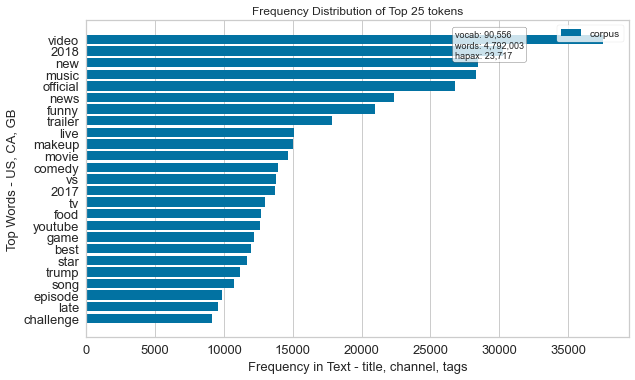

In [13]:
features   = count_vectorizer.get_feature_names()
plt.ylabel('Top Words - US, CA, GB', fontsize = 13)
plt.xlabel('Frequency in Text - title, channel, tags', fontsize = 13)
visualizer = FreqDistVisualizer(features=features, n = 25, orient='h', size=(700, 420))
visualizer.fit(X)
visualizer.ax.tick_params(labelsize=13)
res = visualizer.show()

# Sources

As part of the work in this notebook, we consulted several sources, including stack overflow discussions, Everaldo's slides and GitHub repo, and official documentation (sklearn, NLTK, Yellowbrick, etc). We also referenced the below link for how to use the NLTK toolset for sentiment analysis. 

https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/